[*********************100%%**********************]  3 of 3 completed
Markowitz Optimal Weights: [0.55181589 0.00268362 0.44550048]
Using cpu device


/Users/seoyunbaek/anaconda3/lib/python3.10/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


-----------------------------
| time/              |      |
|    fps             | 4515 |
|    iterations      | 1    |
|    time_elapsed    | 0    |
|    total_timesteps | 2048 |
-----------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 3325          |
|    iterations           | 2             |
|    time_elapsed         | 1             |
|    total_timesteps      | 4096          |
| train/                  |               |
|    approx_kl            | 0.00043094065 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -4.26         |
|    explained_variance   | 2.26e-06      |
|    learning_rate        | 0.0003        |
|    loss                 | 5.39e+08      |
|    n_updates            | 10            |
|    policy_gradient_loss | -0.000757     |
|    std                  | 1             |
|    value_loss           | 9.41e+08      

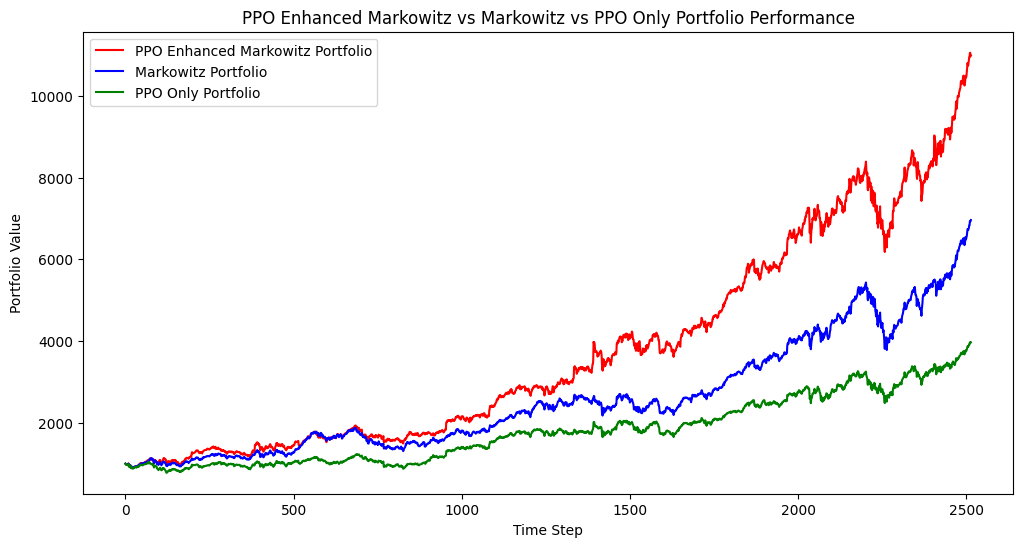

PPO Enhanced Markowitz Performance: Annual Return=0.26, Volatility=0.22, Sharpe Ratio=1.21
Markowitz Performance: Annual Return=0.22, Volatility=0.21, Sharpe Ratio=1.03
PPO Only Performance: Annual Return=0.16, Volatility=0.21, Sharpe Ratio=0.76


In [10]:
import numpy as np
import pandas as pd
import yfinance as yf
from scipy.optimize import minimize
import gym
from gym import spaces
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
import matplotlib.pyplot as plt

# 금융 데이터 다운로드 (예: S&P 500 구성종목)
tickers = ["AAPL", "MSFT", "GOOGL"]
data = yf.download(tickers, start="2010-01-01", end="2020-01-01")["Adj Close"]

# 로그 수익률 계산
returns = np.log(data / data.shift(1)).dropna()

# 마코위츠 최적화 포트폴리오 비중 계산 함수
def markowitz_optimization(returns):
    mean_returns = returns.mean()
    cov_matrix = returns.cov()
    
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix)
    
    def portfolio_annual_performance(weights, mean_returns, cov_matrix):
        returns = np.sum(mean_returns * weights) * 252
        std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252)
        return returns, std
    
    def neg_sharpe_ratio(weights, mean_returns, cov_matrix, risk_free_rate=0):
        p_returns, p_std = portfolio_annual_performance(weights, mean_returns, cov_matrix)
        return -(p_returns - risk_free_rate) / p_std
    
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = (0.0, 1.0)
    bounds = tuple(bound for asset in range(num_assets))
    
    result = minimize(neg_sharpe_ratio, num_assets*[1./num_assets,], args=args, method='SLSQP', bounds=bounds, constraints=constraints)
    
    return result.x

markowitz_weights = markowitz_optimization(returns)
print("Markowitz Optimal Weights:", markowitz_weights)

# 강화학습 환경 구성
class PortfolioEnv(gym.Env):
    def __init__(self, returns, markowitz_weights=None, initial_balance=1000):
        super(PortfolioEnv, self).__init__()
        self.returns = returns
        self.num_assets = returns.shape[1]
        self.initial_balance = initial_balance
        self.markowitz_weights = markowitz_weights if markowitz_weights is not None else np.ones(self.num_assets) / self.num_assets

        self.action_space = spaces.Box(low=-0.1, high=0.1, shape=(self.num_assets,), dtype=np.float32)
        self.observation_space = spaces.Box(low=0, high=np.inf, shape=(1 + self.num_assets + self.num_assets,), dtype=np.float32)

        self.reset()

    def reset(self):
        self.current_step = 0
        self.balance = self.initial_balance
        self.portfolio = self.markowitz_weights
        return self._get_observation()

    def step(self, action):
        if self.current_step >= len(self.returns) - 1:
            done = True
            return self._get_observation(), self.balance, done, {}

        # 액션을 포트폴리오 비중 변화로 해석하고, 기존 마코위츠 비중에 더함
        action = np.clip(action, -0.1, 0.1)
        ppo_portfolio = np.clip(self.portfolio + action, 0, 1)
        ppo_portfolio = ppo_portfolio / np.sum(ppo_portfolio)

        # 앙상블 포트폴리오 비중 계산
        self.portfolio = (self.markowitz_weights + ppo_portfolio) / 2

        # 다음 스텝으로 이동
        self.current_step += 1

        # 현재 스텝의 보상을 계산하고 잔고를 업데이트
        rewards = np.dot(self.portfolio, self.returns.iloc[self.current_step])
        self.balance *= (1 + rewards)

        done = self.current_step == len(self.returns) - 1
        return self._get_observation(), self.balance, done, {}

    def _get_observation(self):
        if self.current_step < len(self.returns):
            obs = np.concatenate(([self.balance], self.portfolio, self.returns.iloc[self.current_step].values))
        else:
            obs = np.concatenate(([self.balance], self.portfolio, np.zeros(self.num_assets)))
        return np.array(obs, dtype=np.float32)

    def render(self, mode='human'):
        plt.figure(figsize=(12, 6))
        plt.plot(self.balance, label='Portfolio Value')
        plt.title('Portfolio Value Over Time')
        plt.xlabel('Time Step')
        plt.ylabel('Portfolio Value')
        plt.legend()
        plt.show()

# 환경 구성 및 PPO 학습
ensemble_env = DummyVecEnv([lambda: PortfolioEnv(returns, markowitz_weights)])
ensemble_model = PPO('MlpPolicy', ensemble_env, verbose=1)
ensemble_model.learn(total_timesteps=10000)

# 백테스트 함수
def backtest(env, model):
    state = env.reset()
    balances = [env.envs[0].initial_balance]
    for t in range(len(env.envs[0].returns) - 1):
        action, _ = model.predict(state)
        next_state, balance, done, _ = env.step(action)
        balances.append(balance[0])
        state = next_state
        if done:
            break
    return balances

# 백테스트 및 성능 평가
ensemble_balances = backtest(ensemble_env, ensemble_model)

def calculate_performance(balances):
    returns = np.diff(balances) / balances[:-1]
    annual_return = np.mean(returns) * 252
    annual_volatility = np.std(returns) * np.sqrt(252)
    sharpe_ratio = annual_return / annual_volatility
    return annual_return, annual_volatility, sharpe_ratio

# 마코위츠 포트폴리오 성능 계산
def backtest_markowitz(returns, weights, initial_balance=1000):
    balances = [initial_balance]
    for t in range(1, len(returns)):
        rewards = np.dot(weights, returns.iloc[t])
        new_balance = balances[-1] * (1 + rewards)
        balances.append(new_balance)
    return balances

markowitz_balances = backtest_markowitz(returns, markowitz_weights)
markowitz_performance = calculate_performance(markowitz_balances)


PPO Enhanced Markowitz Metrics:
Cumulative Return: 9.9836
Max Drawdown: 2.2110
Annual Return: 0.2640
Annual Volatility: 0.2184
Sharpe Ratio: 1.2089
Sortino Ratio: 1.7354

Markowitz Metrics:
Cumulative Return: 5.9599
Max Drawdown: 1.6512
Annual Return: 0.2165
Annual Volatility: 0.2093
Sharpe Ratio: 1.0343
Sortino Ratio: 1.3966

PPO Only Metrics:
Cumulative Return: 2.9685
Max Drawdown: 0.7817
Annual Return: 0.1606
Annual Volatility: 0.2115
Sharpe Ratio: 0.7595
Sortino Ratio: 1.0155

Metrics DataFrame:
                        Cumulative Return  Max Drawdown  Annual Return  \
PPO Enhanced Markowitz           9.983567      2.210955       0.264033   
Markowitz                        5.959909      1.651229       0.216518   
PPO Only                         2.968541      0.781749       0.160620   

                        Annual Volatility  Sharpe Ratio  Sortino Ratio  
PPO Enhanced Markowitz           0.218415      1.208860       1.735427  
Markowitz                        0.209342      1.03

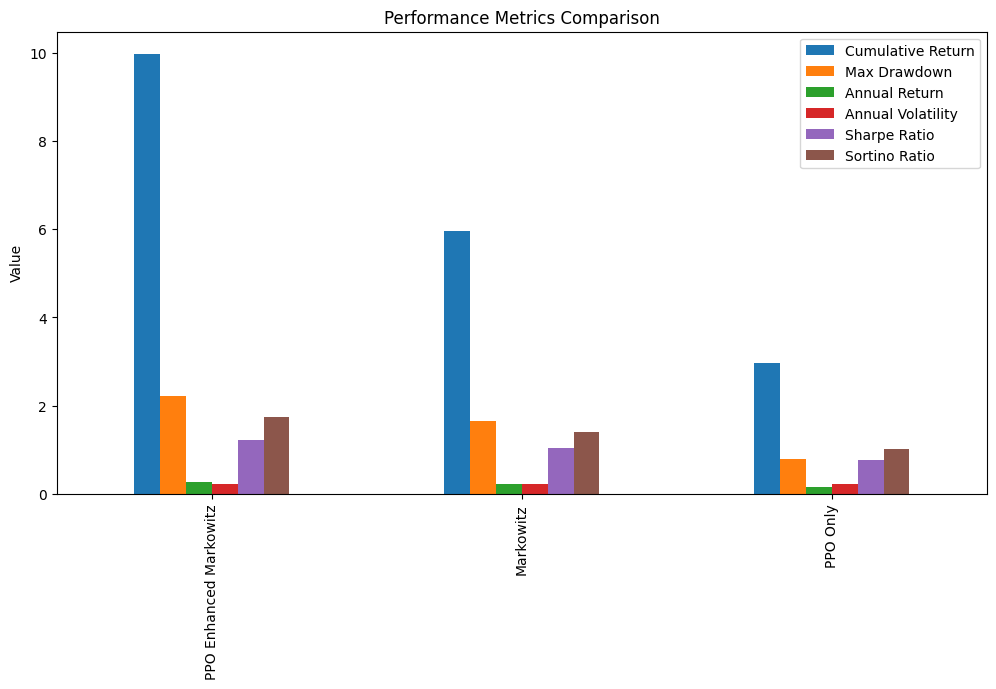

In [12]:
# 추가 성과 지표 계산 함수
def calculate_additional_metrics(balances):
    returns = np.diff(balances) / balances[:-1]
    cumulative_returns = np.cumprod(1 + returns) - 1
    max_drawdown = np.max(np.maximum.accumulate(cumulative_returns) - cumulative_returns)
    annual_return = np.mean(returns) * 252
    annual_volatility = np.std(returns) * np.sqrt(252)
    sharpe_ratio = annual_return / annual_volatility
    sortino_ratio = annual_return / (np.std([r for r in returns if r < 0]) * np.sqrt(252))
    return {
        'Cumulative Return': cumulative_returns[-1],
        'Max Drawdown': max_drawdown,
        'Annual Return': annual_return,
        'Annual Volatility': annual_volatility,
        'Sharpe Ratio': sharpe_ratio,
        'Sortino Ratio': sortino_ratio
    }

# 성과 지표 계산
ppo_metrics = calculate_additional_metrics(ppo_balances)
markowitz_metrics = calculate_additional_metrics(markowitz_balances)
ppo_only_metrics = calculate_additional_metrics(ppo_only_balances)

# 성과 지표 출력
print("\nPPO Enhanced Markowitz Metrics:")
for k, v in ppo_metrics.items():
    print(f"{k}: {v:.4f}")

print("\nMarkowitz Metrics:")
for k, v in markowitz_metrics.items():
    print(f"{k}: {v:.4f}")

print("\nPPO Only Metrics:")
for k, v in ppo_only_metrics.items():
    print(f"{k}: {v:.4f}")

# 성과 지표 표로 정리
metrics_df = pd.DataFrame([ppo_metrics, markowitz_metrics, ppo_only_metrics], index=['PPO Enhanced Markowitz', 'Markowitz', 'PPO Only'])
print("\nMetrics DataFrame:")
print(metrics_df)

# 성과 지표 시각화
metrics_df.plot(kind='bar', figsize=(12, 6))
plt.title('Performance Metrics Comparison')
plt.ylabel('Value')
plt.show()